# EVA8 Session 10 Assignment

## The Dawn of Transformers Part 2

### Goals:
1. Rewrite ViT code using convolutions rather than Linear layers
2. Add class token and use class token position to predict classes for CIFAR 10 Dataset
3. Train rewritten model and provide results

In [1]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

/opt/anaconda3/envs/PhotogradeML/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set Device

In [2]:
## CPU Device
DATA_DIR='./data'
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cpu


In [3]:
# Check that MPS is available
## MPS Device - Using Apple Silicon for accelerating training
DATA_DIR='./data'
import torch
from pprint import pprint
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    device = torch.device("mps")
    
pprint(device)

device(type='mps')


## Define ViT Architecture

### Pre-Norm (Layer Normalization) and Feedforward Layers

In [3]:
# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

class PreNorm(nn.Module):
    def __init__(self, channels, fn):
        super().__init__()
        self.norm = nn.LayerNorm(channels)
        self.fn = fn
    def forward(self, x, **kwargs):
        x = x.transpose(1,-1)
        x = self.norm(x)
        x = x.transpose(-1,1)
        return self.fn(x, **kwargs)
    
class FeedForward(nn.Module):
    def __init__(self, in_channels, ff_hidden_channels, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, ff_hidden_channels, 1),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Conv2d(ff_hidden_channels, in_channels, 1),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

### Attention & Transformer Layers

In [5]:
# class Attention(nn.Module):
#     def __init__(self, in_channels, heads = 8 , head_channels = 64, dropout = 0.):
#         super().__init__()
        
#         self.head_channels = head_channels
#         hidden_channels = head_channels * heads
#         self.heads = heads
#         self.scale = in_channels ** -0.5
#         ## Check dimension to be set below - every slice along dim will sum to 1
#         self.attend = nn.Softmax(dim = -2) #-1)
        
#         self.to_qkv = nn.Conv2d(in_channels, hidden_channels * 3, 1)
#         self.unifyheads = nn.Conv2d(hidden_channels, in_channels, 1)
        
#     def forward(self, x):
        
#         b, c, h, w = x.shape
        
#         qkv = self.to_qkv(x).chunk(3, dim = 1)
        
#         q, k, v = map(lambda t: rearrange(t, 'b (n hd) h w -> b hd n h w', hd = self.heads), qkv)
#         dot_product = k.transpose(-2,-1) @ q

#         scaled = dot_product * self.scale
#         attention = self.attend(scaled)
        
#         out = v @ attention
        
#         out = rearrange(out, 'b hd n h w -> b (n hd) h w')
        
#         unified = self.unifyheads(out)
        
#         return unified
        


# ## Transformer Block is defined as nn.ModuleList(), which is then stacker using for loop in range(depth)
# '''
# Transformer block here is written incorrectly, it doesn't stack the attention + ff layers in a transformer block correctly
# '''
# class Transformer(nn.Module):
#     def __init__(self, in_channels, depth, heads, head_channels, ff_hidden_channels, dropout = 0.):
#         super().__init__()
#         self.layers = nn.ModuleList([])
#         self.depth = depth
#         for _ in range(depth):
#             self.layers.append(nn.ModuleList([
#                 PreNorm(in_channels, Attention(in_channels, heads = heads, head_channels = head_channels,
#                                                 dropout = dropout)),
#                 PreNorm(in_channels, FeedForward(in_channels, ff_hidden_channels, dropout = dropout))
#             ]))
#     def forward(self, x):
#         for attn, ff in self.layers:
#             ## Residual connections are added here
#             x = attn(x) + x
#             x = ff(x) + x
#             return x

## Transformer Block written correctly

In [4]:
class Attention(nn.Module):
    def __init__(self, in_channels, heads = 8 , head_channels = 64, dropout = 0.):
        super().__init__()
        
        self.head_channels = head_channels
        hidden_channels = head_channels * heads
        self.heads = heads
        self.scale = in_channels ** -0.5
        ## Check dimension to be set below - every slice along dim will sum to 1
        self.attend = nn.Softmax(dim = -2) #-1)
        
        self.to_qkv = nn.Conv2d(in_channels, hidden_channels * 3, 1)
        self.unifyheads = nn.Conv2d(hidden_channels, in_channels, 1)
        
    def forward(self, x):
        
        b, c, h, w = x.shape
        
        qkv = self.to_qkv(x).chunk(3, dim = 1)
        
        q, k, v = map(lambda t: rearrange(t, 'b (n hd) h w -> b hd n h w', hd = self.heads), qkv)
        dot_product = k.transpose(-2,-1) @ q

        scaled = dot_product * self.scale
        attention = self.attend(scaled)
        
        out = v @ attention
        
        out = rearrange(out, 'b hd n h w -> b (n hd) h w')
        
        unified = self.unifyheads(out)
        
        return unified
        
# class Residual(nn.Module):
#     def __init__(self, *layers):
#         super().__init__()
#         self.residual = nn.Sequential(*layers)
#         self.gamma = nn.Parameter(torch.zeros(1))
    
#     def forward(self, x):
#         return x + self.gamma * self.residual(x)
    
class TransformerStack(nn.Sequential):
    def __init__(self, in_channels, depth, heads, head_channels, ff_hidden_channels, dropout = 0.):
        layers = [TransformerBlock(in_channels, depth, heads, head_channels, ff_hidden_channels, dropout) for _ in range(depth)]
        super().__init__(*layers)

class TransformerBlock(nn.Module):
    def __init__(self, in_channels, depth, heads, head_channels, ff_hidden_channels, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        self.gamma = nn.Parameter(torch.zeros(1))
        self.layers.append(nn.ModuleList([
            PreNorm(in_channels, Attention(in_channels, heads = heads, head_channels = head_channels,
                                            dropout = dropout)),
            PreNorm(in_channels, FeedForward(in_channels, ff_hidden_channels, dropout = dropout))
        ]))
    def forward(self, x):
        for attn, ff in self.layers:
            ## Residual connections are added here
            x = self.gamma * attn(x) + x
            x = self.gamma * ff(x) + x
            return x

### Vision Transformer

In [5]:
class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, hidden_channels, depth, heads, head_channels, ff_hidden_channels,
                 pool = 'cls', channels = 3, trans_dropout = 0., emb_dropout = 0., head_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'
        
        out_channels = 32
        self.to_patch_embedding = nn.Sequential(
            #Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Conv2d(channels, hidden_channels, 3, padding=1),
            nn.GELU(),
            nn.Conv2d(hidden_channels, out_channels, patch_size, stride=patch_size)
        )
        
        shape = (image_size//patch_size, image_size//patch_size)
        
        ## Have changed torch.randn to torch.Tensor - need to figure out the difference
        self.pos_embedding = nn.Parameter(torch.Tensor(1, out_channels + 1, *shape))
        self.cls_token = nn.Parameter(torch.randn(1, 1, *shape))
        self.emb_dropout = nn.Dropout(emb_dropout)
        #self.transformer = Transformer(out_channels + 1, depth, heads, head_channels, ff_hidden_channels, trans_dropout)
        self.transformer = TransformerStack(out_channels + 1, depth, heads, head_channels, ff_hidden_channels, trans_dropout)
        
        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            #LayerNormChannels(1),
            PreNorm(1, nn.Identity()),
            nn.GELU(),
            nn.AdaptiveAvgPool2d(5),
            nn.Flatten(),
            nn.Dropout(head_dropout),
            nn.Linear(25, num_classes)
        )
        
        self.reset_parameters()
    
    def reset_parameters(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1.)
                nn.init.zeros_(m.bias)
            elif isinstance(m, ViT):
                nn.init.normal_(m.pos_embedding, mean=0.0, std=0.02)
#             elif isinstance(m, Attention):
#                 nn.init.normal_(m.pos_enc, mean=0.0, std=0.02)
            elif isinstance(m, TransformerBlock):
                nn.init.zeros_(m.gamma)

    def forward(self, img):
        x = self.to_patch_embedding(img)
        
        b, n, h, w = x.shape
        ## Double check later how cls_tokens are being generated and concatenated
        cls_tokens = repeat(self.cls_token, '() n h w -> b n h w', b = b)
        x = torch.cat((cls_tokens, x), dim = 1)
        
        position_embedding = self.pos_embedding
        
        x += self.pos_embedding[:,:(n+1)]
        x = self.emb_dropout(x)
        
        x = self.transformer(x)

        #x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]
        x = x.mean(dim = 2) if self.pool == 'mean' else x[:,0,:,:]

        #x = self.to_latent(x)
        
        y = torch.unsqueeze(x,1)
        return self.mlp_head(y)


## Define Model & Transfer to Device

In [6]:
model = ViT(image_size = 32, 
            patch_size = 2, 
            num_classes = 10, 
            hidden_channels = 32, 
            depth = 4, 
            heads = 8,
            head_channels = 8,
            ff_hidden_channels = 32,
            trans_dropout = 0., emb_dropout = 0., head_dropout = 0.1)

In [7]:
from torchsummary import summary
model.to(DEVICE)
summary(model, input_size=(3, 32, 32))
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              GELU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 32, 16, 16]           4,128
           Dropout-4           [-1, 33, 16, 16]               0
         LayerNorm-5           [-1, 16, 16, 33]              66
            Conv2d-6          [-1, 192, 16, 16]           6,528
           Softmax-7         [-1, 8, 8, 16, 16]               0
            Conv2d-8           [-1, 33, 16, 16]           2,145
         Attention-9           [-1, 33, 16, 16]               0
          PreNorm-10           [-1, 33, 16, 16]               0
        LayerNorm-11           [-1, 16, 16, 33]              66
           Conv2d-12           [-1, 32, 16, 16]           1,088
             GELU-13           [-1, 32, 16, 16]               0
          Dropout-14           [-1, 32,

In [10]:
model.to(device)

ViT(
  (to_patch_embedding): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GELU(approximate='none')
    (2): Conv2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
  )
  (emb_dropout): Dropout(p=0.0, inplace=False)
  (transformer): TransformerStack(
    (0): TransformerBlock(
      (layers): ModuleList(
        (0): ModuleList(
          (0): PreNorm(
            (norm): LayerNorm((33,), eps=1e-05, elementwise_affine=True)
            (fn): Attention(
              (attend): Softmax(dim=-2)
              (to_qkv): Conv2d(33, 192, kernel_size=(1, 1), stride=(1, 1))
              (unifyheads): Conv2d(64, 33, kernel_size=(1, 1), stride=(1, 1))
            )
          )
          (1): PreNorm(
            (norm): LayerNorm((33,), eps=1e-05, elementwise_affine=True)
            (fn): FeedForward(
              (net): Sequential(
                (0): Conv2d(33, 32, kernel_size=(1, 1), stride=(1, 1))
                (1): GELU(approximate='none')
   

In [11]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

Number of parameters: 57,922


## Define Dataloaders

In [8]:
IMAGE_SIZE = 32

NUM_CLASSES = 10
NUM_WORKERS = 4
BATCH_SIZE = 512
EPOCHS = 5

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-1

cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2471, 0.2435, 0.2616)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.75, 1.0), ratio=(1.0, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandAugment(num_ops=1, magnitude=8),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
    transforms.RandomErasing(p=0.25)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=NUM_WORKERS)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=NUM_WORKERS)

Files already downloaded and verified
Files already downloaded and verified


## Run on MPS (Apple Silicon GPU) Device - GradScaler() and Autocast() unavailable

In [16]:
import time
from tqdm import tqdm

clip_norm = True
lr_schedule = lambda t: np.interp([t], [0, EPOCHS*2//5, EPOCHS*4//5, EPOCHS], 
                                  [0, 0.01, 0.01/20.0, 0])[0]

#model = nn.DataParallel(model, device_ids=[0]).cuda()
opt = optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()

for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1)
    start = time.time()
    train_loss, train_acc, n = 0, 0, 0
    pbar = tqdm(trainloader)
    
    for i, (X, y) in enumerate(pbar):
    #for i, (X, y) in enumerate(trainloader):
        model.train()
        #X, y = X.cuda(), y.cuda()
        X, y = X.to(device), y.to(device)

        lr = lr_schedule(epoch + (i + 1)/len(trainloader))
        opt.param_groups[0].update(lr=lr)

        opt.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(X)
            loss = criterion(output, y)
        
        scaler.scale(loss).backward()
        if clip_norm:
            scaler.unscale_(opt)
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(opt)
        scaler.update()
        
        train_loss += loss.item() * y.size(0)
        train_acc += (output.max(1)[1] == y).sum().item()
        n += y.size(0)
        
        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} LR={lr:0.5f} Accuracy={100 * train_acc/n:0.2f}')
        
    model.eval()
    test_acc, m = 0, 0
    with torch.no_grad():
        for i, (X, y) in enumerate(testloader):
            X, y = X.to(device), y.to(device)
            #X, y = X.cuda(), y.cuda()
            with torch.cuda.amp.autocast():
                output = model(X)
            test_acc += (output.max(1)[1] == y).sum().item()
            m += y.size(0)

    print(f'ViT: Epoch: {epoch + 1} | Train Acc: {train_acc/n:.4f}, Test Acc: {test_acc/m:.4f}, Time: {time.time() - start:.1f}, lr: {lr:.6f}')


EPOCH: 1


Loss=2.3171136379241943 Batch_id=97 LR=0.00100 Accuracy=9.99: 100%|█| 98/98 [01:


ViT: Epoch: 1 | Train Acc: 0.0999, Test Acc: 0.1000, Time: 117.9, lr: 0.001000
EPOCH: 2


Loss=2.3037233352661133 Batch_id=97 LR=0.00200 Accuracy=9.92: 100%|█| 98/98 [01:


ViT: Epoch: 2 | Train Acc: 0.0992, Test Acc: 0.1000, Time: 118.0, lr: 0.002000
EPOCH: 3


Loss=2.307962417602539 Batch_id=97 LR=0.00300 Accuracy=9.81: 100%|█| 98/98 [01:2


ViT: Epoch: 3 | Train Acc: 0.0981, Test Acc: 0.1000, Time: 118.2, lr: 0.003000
EPOCH: 4


Loss=2.3071272373199463 Batch_id=97 LR=0.00400 Accuracy=9.88: 100%|█| 98/98 [01:


ViT: Epoch: 4 | Train Acc: 0.0988, Test Acc: 0.1000, Time: 118.2, lr: 0.004000
EPOCH: 5


Loss=2.3039486408233643 Batch_id=97 LR=0.00500 Accuracy=9.90: 100%|█| 98/98 [01:


ViT: Epoch: 5 | Train Acc: 0.0990, Test Acc: 0.1000, Time: 118.5, lr: 0.005000
EPOCH: 6


Loss=2.303518056869507 Batch_id=97 LR=0.00600 Accuracy=10.09: 100%|█| 98/98 [01:


ViT: Epoch: 6 | Train Acc: 0.1009, Test Acc: 0.1000, Time: 118.2, lr: 0.006000
EPOCH: 7


Loss=2.3056507110595703 Batch_id=97 LR=0.00700 Accuracy=9.93: 100%|█| 98/98 [01:


ViT: Epoch: 7 | Train Acc: 0.0993, Test Acc: 0.1000, Time: 118.1, lr: 0.007000
EPOCH: 8


Loss=2.2998650074005127 Batch_id=97 LR=0.00800 Accuracy=10.05: 100%|█| 98/98 [01


KeyboardInterrupt: 

## CPU Test

In [9]:
import time
from tqdm import tqdm

clip_norm = True
lr_schedule = lambda t: np.interp([t], [0, EPOCHS*2//5, EPOCHS*4//5, EPOCHS], 
                                  [0, 0.01, 0.01/20.0, 0])[0]

model.to(DEVICE)
#model = nn.DataParallel(model, device_ids=[0]).cuda()
opt = optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()

for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1)
    start = time.time()
    train_loss, train_acc, n = 0, 0, 0
    pbar = tqdm(trainloader)
    
    for i, (X, y) in enumerate(pbar):
    #for i, (X, y) in enumerate(trainloader):
        model.train()
        #X, y = X.cuda(), y.cuda()
        X, y = X.to(DEVICE), y.to(DEVICE)

        lr = lr_schedule(epoch + (i + 1)/len(trainloader))
        opt.param_groups[0].update(lr=lr)

        opt.zero_grad()
        with torch.autocast(device_type="cpu", dtype=torch.bfloat16):
            output = model(X)
            loss = criterion(output, y)

        scaler.scale(loss).backward()
        if clip_norm:
            scaler.unscale_(opt)
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(opt)
        scaler.update()
        
        train_loss += loss.item() * y.size(0)
        train_acc += (output.max(1)[1] == y).sum().item()
        n += y.size(0)
        
        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} LR={lr:0.5f} Accuracy={100 * train_acc/n:0.4f}')
        
    model.eval()
    test_acc, m = 0, 0
    with torch.no_grad():
        for i, (X, y) in enumerate(testloader):
            X, y = X.to(DEVICE), y.to(DEVICE)
            #X, y = X.cuda(), y.cuda()
            with torch.autocast(device_type="cpu", dtype=torch.bfloat16):
                output = model(X)
            test_acc += (output.max(1)[1] == y).sum().item()
            m += y.size(0)

    print(f'ViT: Epoch: {epoch + 1} | Train Acc: {train_acc/n:.4f}, Test Acc: {test_acc/m:.4f}, Time: {time.time() - start:.1f}, lr: {lr:.6f}')


/opt/anaconda3/envs/PhotogradeML/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


EPOCH: 1


Loss=2.302541971206665 Batch_id=43 LR=0.00224 Accuracy=9.7479:  45%|▍| 44/98 [06


KeyboardInterrupt: 

# Gradcam

In [17]:
## Clone Deep Learning Utils Repo
!git clone https://github.com/a-pujahari/Torch_CV_Utils.git

Cloning into 'Torch_CV_Utils'...
remote: Enumerating objects: 217, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (24/24), done.
Receiving objects: 100% (217/217), 54.55 KiB | 1.56 MiB/s, done.
remote: Total 217 (delta 9), reused 0 (delta 0), pack-reused 193
Resolving deltas: 100% (124/124), done.


In [10]:
from Torch_CV_Utils import main
from Torch_CV_Utils.utils import data_handling, train, test, gradcam, helpers, augmentation

## Misclassified Images

Total wrong predictions are 9000


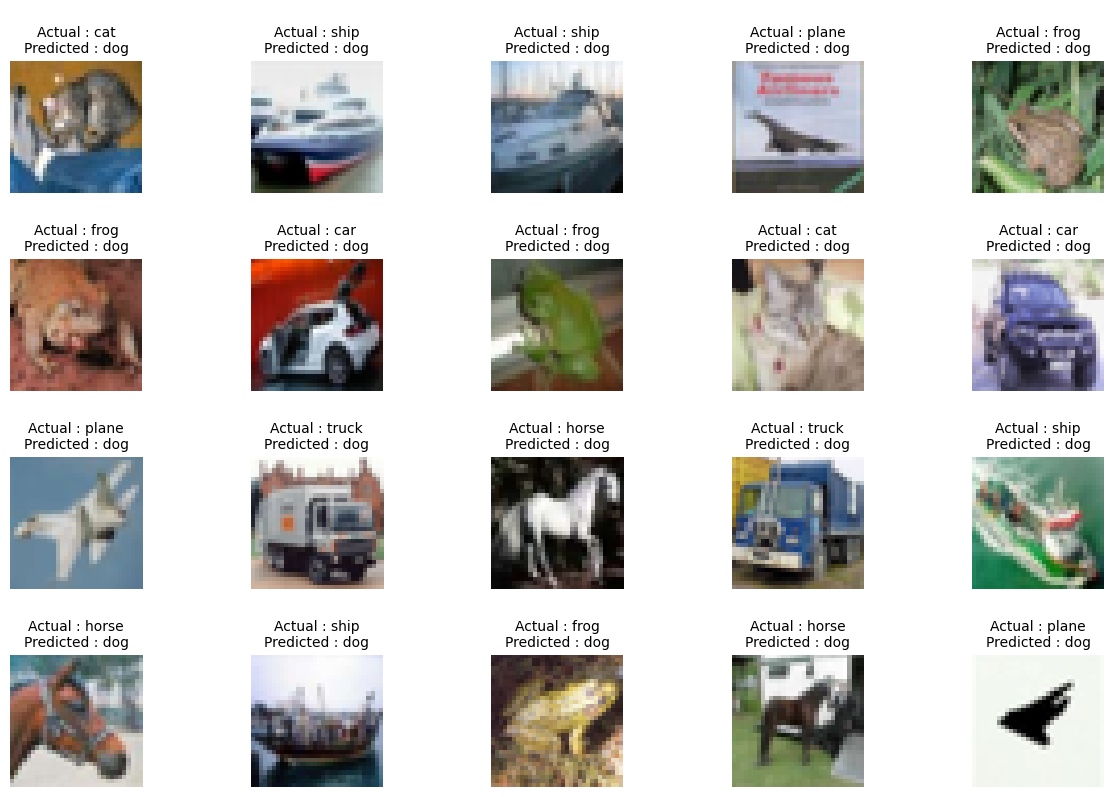

In [12]:
misclassified_images = helpers.wrong_predictions(model, testloader, DEVICE)
helpers.plot_misclassified(misclassified_images, cifar10_mean, cifar10_std, 20)

Generating Grad-CAM @mlp_head.0


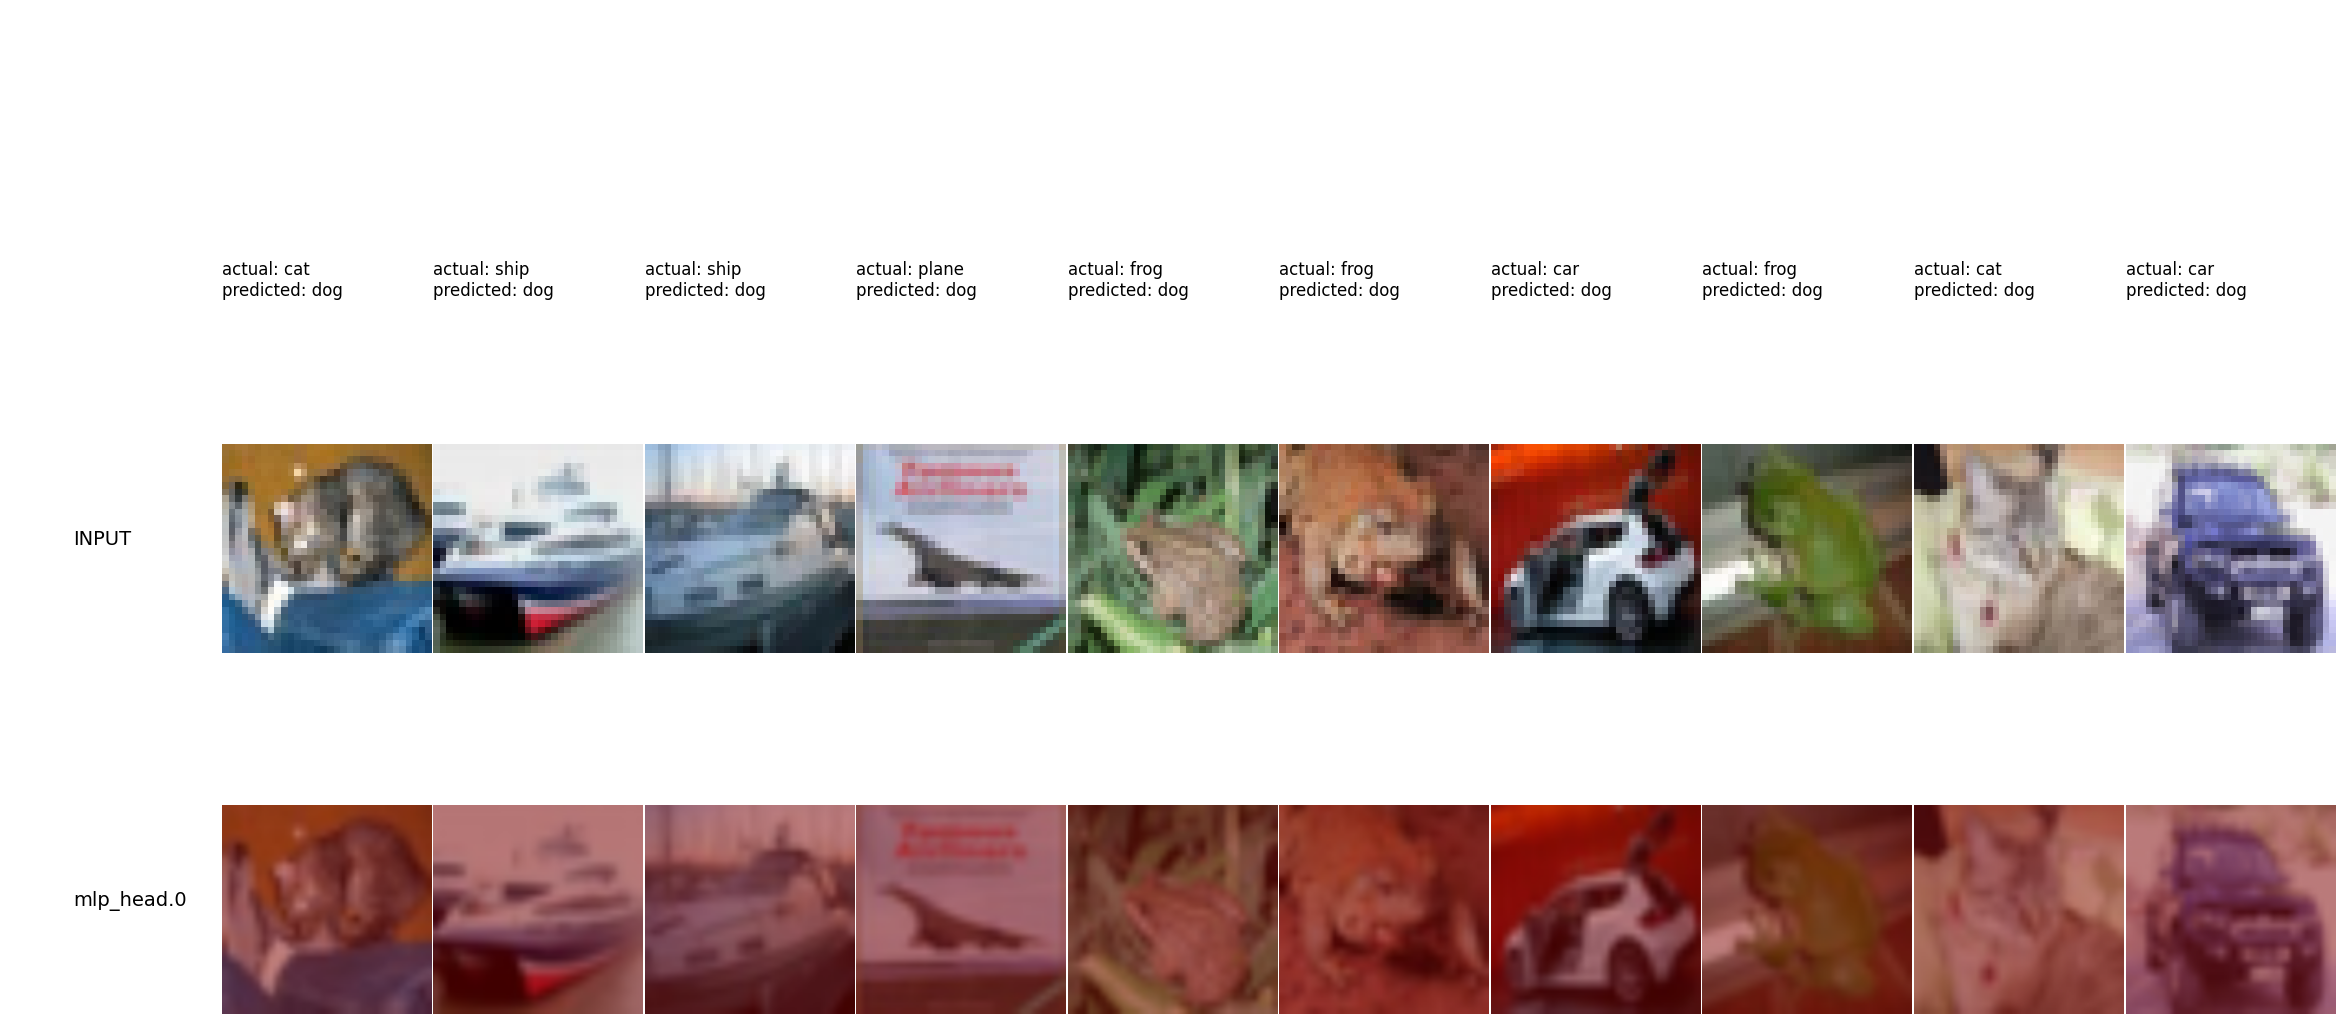

In [14]:
target_layers = ["mlp_head.0"]
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
gradcam_output, probs, predicted_classes = gradcam.generate_gradcam(misclassified_images[:10], model, target_layers, DEVICE)
gradcam.plot_gradcam(gradcam_output, target_layers, classes, (3, 32, 32),predicted_classes, misclassified_images[:10], cifar10_mean, cifar10_std)

In [24]:
for name, module in model.named_modules():
    print(name)


to_patch_embedding
to_patch_embedding.0
to_patch_embedding.1
to_patch_embedding.2
emb_dropout
transformer
transformer.0
transformer.0.layers
transformer.0.layers.0
transformer.0.layers.0.0
transformer.0.layers.0.0.norm
transformer.0.layers.0.0.fn
transformer.0.layers.0.0.fn.attend
transformer.0.layers.0.0.fn.to_qkv
transformer.0.layers.0.0.fn.unifyheads
transformer.0.layers.0.1
transformer.0.layers.0.1.norm
transformer.0.layers.0.1.fn
transformer.0.layers.0.1.fn.net
transformer.0.layers.0.1.fn.net.0
transformer.0.layers.0.1.fn.net.1
transformer.0.layers.0.1.fn.net.2
transformer.0.layers.0.1.fn.net.3
transformer.0.layers.0.1.fn.net.4
transformer.1
transformer.1.layers
transformer.1.layers.0
transformer.1.layers.0.0
transformer.1.layers.0.0.norm
transformer.1.layers.0.0.fn
transformer.1.layers.0.0.fn.attend
transformer.1.layers.0.0.fn.to_qkv
transformer.1.layers.0.0.fn.unifyheads
transformer.1.layers.0.1
transformer.1.layers.0.1.norm
transformer.1.layers.0.1.fn
transformer.1.layers.0.1.